# **Recommendation system**
here we will build a recommender system using Model-based Collaborative-filtering tecnique in PyTorch and applying Bayesian average method for cold start problem.

## Step 01: **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from src.recommender import recommend
from src.model import MF, MF_bias, train_epochs

from scipy.sparse import csr_matrix

#np.random.seed(seed=33) # for reproducability

## Step 02: **Load Data**

In [2]:
movies = pd.read_csv("data/ml-latest-small/movies.csv")
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [3]:
ratings = pd.read_csv("data/ml-latest-small/ratings.csv")
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


## Step 03: **Data Pre-processing**

#### **Removing unrated movies from movies dataset**

In [4]:
ex1 = np.setdiff1d(ratings.movieId.unique(), movies.movieId.unique()).tolist()
print(f"No. of movies in ratings.csv but not in movies.csv: {len(ex1)}")
ex2 = np.setdiff1d(movies.movieId.unique(), ratings.movieId.unique()).tolist()
print(f"No. of movies in movies.csv but not in ratings.csv: {len(ex2)}")

# remove the extra movies form movies.csv which are not in ratings.csv
movies = movies[movies.movieId.isin(ex2) == False]
movies.reset_index(drop=True, inplace=True) # reset the index after removing some rows
print("removed extra movies from movies.csv ----------")

ex1 = np.setdiff1d(ratings.movieId.unique(), movies.movieId.unique()).tolist()
print(f"No. of movies in ratings.csv but not in movies.csv: {len(ex1)}")
ex2 = np.setdiff1d(movies.movieId.unique(), ratings.movieId.unique()).tolist()
print(f"No. of movies in movies.csv but not in ratings.csv: {len(ex2)}")

No. of movies in ratings.csv but not in movies.csv: 0
No. of movies in movies.csv but not in ratings.csv: 18
removed extra movies from movies.csv ----------
No. of movies in ratings.csv but not in movies.csv: 0
No. of movies in movies.csv but not in ratings.csv: 0


#### **Encoding**
We encode the data to have contiguous id's for users and movies. You can think about this as a categorical encoding of our two categorical variables `userId` and `movieId`.

In [5]:
lbl_user = LabelEncoder()
lbl_movie = LabelEncoder()
lbl2_movie = LabelEncoder()
ratings.userId = lbl_user.fit_transform(ratings.userId.values)
movies.movieId = lbl_movie.fit_transform(movies.movieId.values)
ratings.movieId = lbl2_movie.fit_transform(ratings.movieId.values)

### **Retrieve Movies Genres**

In the movies dataset, `genres` is expressed as a string with a pipe `|` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.

In [6]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head(3)

,movieId,title,genres
0,0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,2,Grumpier Old Men (1995),"[Comedy, Romance]"


## Step 04: **Exploratory Data Analysis**

In [7]:
sparsity = len(ratings.rating) / (ratings.userId.nunique() * ratings.movieId.nunique())
print(f"Matrix Sparsity: {round(sparsity*100, 2)}%")

Matrix Sparsity: 1.7%


In [8]:
print("*** movies.csv ***")
print(f"No. of movies: ------------------------ {movies.shape[0]}")
print(f"No. of unique movies: ----------------- {movies.movieId.nunique()}   (min: {movies.movieId.min()}, max: {movies.movieId.max()})")
print("")
print("*** ratings.csv ***")
print(f"shape: {ratings.shape}")

n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()
n_ratings_per_user = ratings.groupby(['userId'])[['rating']].count()
n_ratings_per_movie = ratings.groupby(['movieId'])[['rating']].count()

print(f"No. of ratings: ----------------------- {n_ratings}")
print(f"No. of unique users: ------------------ {n_users}    (min: {ratings.userId.min()}, max: {ratings.userId.max()})")
print(f"No. of unique movieId's: -------------- {n_movies}   (min: {ratings.movieId.min()}, max: {ratings.movieId.max()})")
print(70*'-')
print(f"No. of ratings per user  - | Min:{n_ratings_per_user.min().item()} | Avg:{round(n_ratings/n_users, 2)} | Max:{n_ratings_per_user.max().item()} |") # TEST
#print(f"Average number of ratings per user: --- {round(n_ratings/n_users, 2)}")
#print(f"Least active user rated {n_ratings_per_user.min().item()} movies.")
#print(f"Most active user rated {n_ratings_per_user.max().item()} movies.")
#print('')
print(f"No. of ratings per movie - | Min:{n_ratings_per_movie.min().item()}  | Avg:{round(n_ratings/n_movies, 2)} | Max:{n_ratings_per_movie.max().item()}  |") # TEST
#print(f"Average number of ratings per movie: -- {round(n_ratings/n_movies, 2)}")
#print(f"Least rated movie has {n_ratings_per_movie.min().item()} ratings.")
#print(f"Most rated movie has {n_ratings_per_movie.max().item()} ratings.")
print(70*'-')
print(f"Mean global rating: {round(ratings['rating'].mean(), 2)}")
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(), 2)}")

*** movies.csv ***
No. of movies: ------------------------ 9724
No. of unique movies: ----------------- 9724   (min: 0, max: 9723)

*** ratings.csv ***
shape: (100836, 4)
No. of ratings: ----------------------- 100836
No. of unique users: ------------------ 610    (min: 0, max: 609)
No. of unique movieId's: -------------- 9724   (min: 0, max: 9723)
----------------------------------------------------------------------
No. of ratings per user  - | Min:20 | Avg:165.3 | Max:2698 |
No. of ratings per movie - | Min:1  | Avg:10.37 | Max:329  |
----------------------------------------------------------------------
Mean global rating: 3.5
Mean rating per user: 3.66


In [9]:
ratings.rating.unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [10]:
genres_dict = {}
for genres in movies['genres']:
    for genre in genres:
        if genre in genres_dict:
            genres_dict[genre] += 1
        else:
            genres_dict[genre] = 1
print(f"There are {len(genres_dict.keys())} genres.")
genres_dict

There are 20 genres.


{'Adventure': 1262,
 'Animation': 610,
 'Children': 664,
 'Comedy': 3753,
 'Fantasy': 778,
 'Romance': 1591,
 'Drama': 4349,
 'Action': 1828,
 'Crime': 1196,
 'Thriller': 1889,
 'Horror': 977,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 381,
 'Musical': 333,
 'Documentary': 438,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 85,
 '(no genres listed)': 34}

In [11]:
b = sorted(genres_dict, key=genres_dict.get, reverse=True)[0:5]
print("The 5 most common genres:")
for i in b:
    print(f"{i}, {genres_dict[i]} movies")

The 5 most common genres:
Drama, 4349 movies
Comedy, 3753 movies
Thriller, 1889 movies
Action, 1828 movies
Romance, 1591 movies


In [12]:
A = ratings.groupby(['movieId'])[['rating']].mean()
B = ratings.groupby(['movieId'])[['rating']].count()
stats = pd.merge(A, B, on='movieId')
stats.columns = ['rating_avg', 'count']
stats = pd.merge(stats, movies, on='movieId')
#stats = stats.drop(['genres'], axis=1)
stats = stats[['movieId', 'title', 'count', 'rating_avg', 'genres']]
stats.head()

,movieId,title,count,rating_avg,genres
0,0,Toy Story (1995),215,3.920930,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,Jumanji (1995),110,3.431818,"[Adventure, Children, Fantasy]"
2,2,Grumpier Old Men (1995),52,3.259615,"[Comedy, Romance]"
3,3,Waiting to Exhale (1995),7,2.357143,"[Comedy, Drama, Romance]"
4,4,Father of the Bride Part II (1995),49,3.071429,[Comedy]


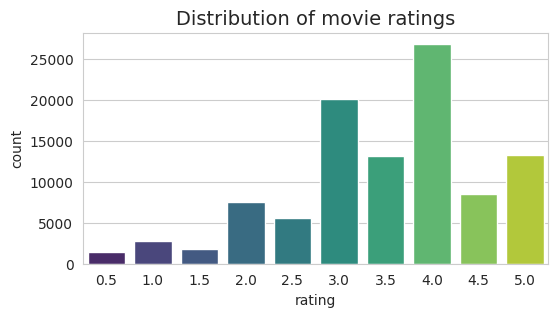

In [13]:
sns.set_style("whitegrid")
plt.figure(figsize=(6,3))
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

The most common rating is 4.0, while lower ratings such as 0.5 or 1.0 are much more rare. it deduces that users mostly rate the movies they liked.

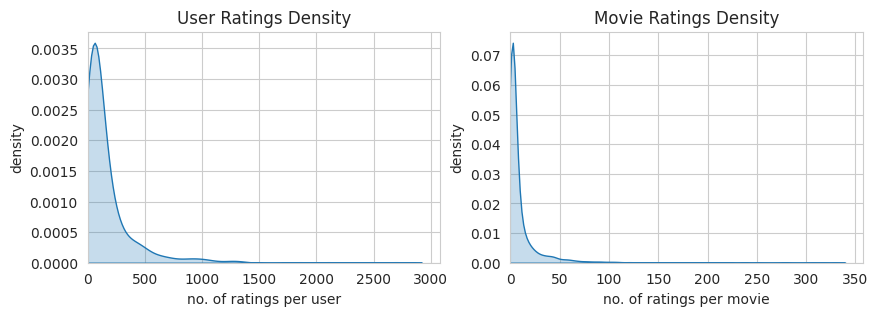

In [14]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user.values.squeeze(), shade=True)
plt.xlim(0)
plt.title("User Ratings Density")
plt.xlabel("no. of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie.values.squeeze(), shade=True)
plt.xlim(0)
plt.title("Movie Ratings Density")
plt.xlabel("no. of ratings per movie")
plt.ylabel("density")
plt.show()

### **Best vs. Worst Movie**
which movie has the lowest and highest average rating?

In [15]:
worst = stats[stats['rating_avg']==stats['rating_avg'].min()].sort_values('count', ascending=True).iloc[0,:]
best = stats[stats['rating_avg']==stats['rating_avg'].max()].sort_values('count', ascending=False).iloc[0,:]
pd.DataFrame(
    {
    'movieId':[worst['movieId'], best['movieId']], 
    'title':[worst['title'], best['title']], 
    'average rating':[worst['rating_avg'], best['rating_avg']], 
    'No. of votes':[worst['count'], best['count']]
    }, 
    index=['Worst Movie', 'Best Movie']
    )

,movieId,title,average rating,No. of votes
Worst Movie,2685,Gypsy (1962),0.5,1
Best Movie,48,Lamerica (1994),5.0,2


Both movies have only 2 rates. A better approach for evaluating movie popularity is to look at the Bayesian average.

### Step 05: **Bayesian Average** (IMDB's Weighted Rating)

$s_i = w_i \cdot A_i + (1 - w_i) \cdot S$

where
* $A_i$ : average (arithmetic mean) rating of the $i^{\text{th}}$ item
* $S$ : average (arithmetic mean) rating of all items
* $w_i$ : weight given to $A_i$

$w_i = \dfrac{m_i}{m_i + m_{\text{avg}}}$

where
* $m_i$ : number of ratings for $i^{\text{th}}$ item
* $m_{\text{avg}}$ : average number of ratings of all items

**Note:** $m_{\text{avg}}$ can be also minimum votes required to be listed in the chart

$s_i = \dfrac{m_i}{m_i + m_{\text{avg}}} \cdot A_i + \dfrac{m_{\text{avg}}}{m_i + m_{\text{avg}}} \cdot S$

In [16]:
A = stats['rating_avg']         # average rating of movie
S = stats['rating_avg'].mean()  # average rating of all items
m = stats['count']              # no. of rating of movies
m_avg = stats['count'].mean()   # average no. of rating of all movies
w = m / (m + m_avg)             # calculate the weight
x = w*A + (1-w)*S               # calculate bayesian average for all movies
stats['bayesian_avg'] = x       # adding the bayesian averages
stats = stats.sort_values('bayesian_avg', ascending=False)
stats = stats[['movieId', 'title', 'count', 'rating_avg', 'bayesian_avg', 'genres']]

### BEST Movies

In [17]:
stats.head()

,movieId,title,count,rating_avg,bayesian_avg,genres
277,277,"Shawshank Redemption, The (1994)",317,4.429022,4.392070,"[Crime, Drama]"
659,659,"Godfather, The (1972)",192,4.289062,4.236457,"[Crime, Drama]"
2224,2224,Fight Club (1999),218,4.272936,4.227052,"[Action, Crime, Drama, Thriller]"
224,224,Star Wars: Episode IV - A New Hope (1977),251,4.231076,4.192646,"[Action, Adventure, Sci-Fi]"
46,46,"Usual Suspects, The (1995)",204,4.237745,4.190567,"[Crime, Mystery, Thriller]"


### WORST Movies

In [18]:
stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,title,count,rating_avg,bayesian_avg,genres
1172,1172,Speed 2: Cruise Control (1997),19,1.605263,2.190377,"[Action, Romance, Thriller]"
2679,2679,Battlefield Earth (2000),19,1.657895,2.224426,"[Action, Sci-Fi]"
1372,1372,Godzilla (1998),33,1.954545,2.267268,"[Action, Sci-Fi, Thriller]"
1144,1144,Anaconda (1997),27,1.925926,2.296800,"[Action, Adventure, Thriller]"
1988,1988,Superman IV: The Quest for Peace (1987),16,1.687500,2.306841,"[Action, Adventure, Sci-Fi]"


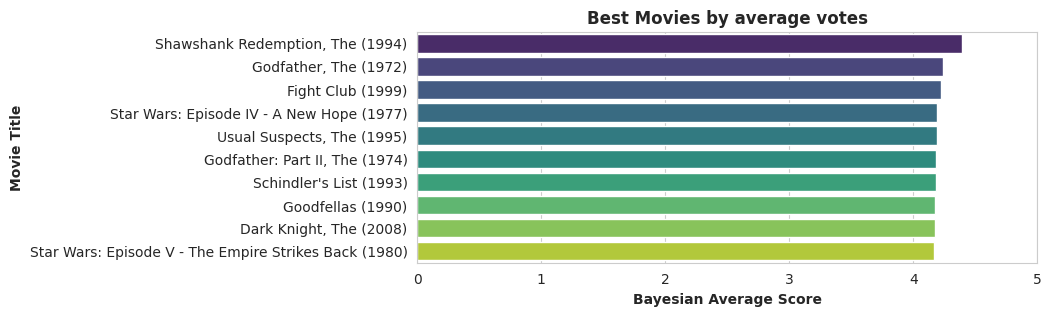

In [19]:
#sns.set_style("whitegrid")
plt.figure(figsize=(8,3))
ax = sns.barplot(x=stats['bayesian_avg'].head(10), y=stats['title'].head(10), data=stats, palette="viridis")
plt.xlim(0, 5)
plt.title('Best Movies by average votes', weight='bold')
plt.xlabel('Bayesian Average Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')
plt.show()

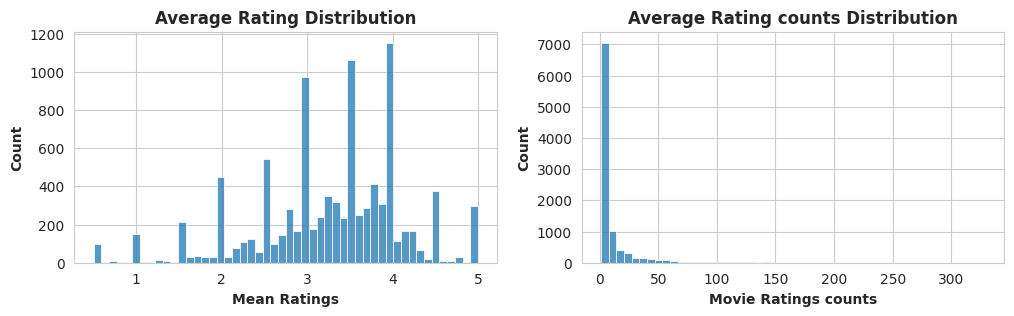

In [20]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
ax = sns.histplot(stats['rating_avg'], bins=50, palette="viridis")
plt.xlabel('Mean Ratings', weight='bold')
plt.ylabel('Count', weight='bold')
plt.title("Average Rating Distribution", weight='bold')
#plt.show()

#sns.set_style("whitegrid")
#plt.figure(figsize=(8,4))
plt.subplot(1,2,2)
ax = sns.histplot(stats['count'], bins=50, palette="viridis")
plt.xlabel('Movie Ratings counts', weight='bold')
plt.ylabel('Count', weight='bold')
plt.title("Average Rating counts Distribution", weight='bold')
plt.show()

<Figure size 1200x300 with 0 Axes>

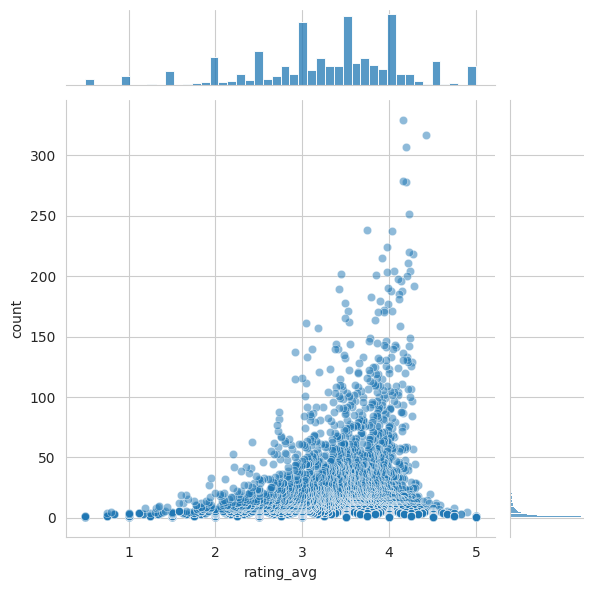

In [21]:
plt.figure(figsize=(12,3))
ax = sns.jointplot(x='rating_avg', y='count', data=stats, alpha=0.5)
plt.show()

### Step 06: **Split Data**